1. Voting Classifier

In [1]:
# Voting Classifier

# 로지스틱 회귀와 KNN을 기반으로 한 보팅 분류기
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [ ]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

# 만약 GPU를 사용 가능하다면 device 값이 cuda가 되고, 아니라면 cpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [ ]:
# 개별 모델은 로지스틱 회귀와 KNN임
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=8)

# 개별 모델을 소프트 보팅(각각의 확률의 평균을 통해 최종 분류 결과 결정)
# estimators : 리스트 형태로 여러개의 튜플 형식의 분류기들을 입력, voting: soft, hard 선택

vo_clf = VotingClassifier(estimators = [('LR',lr_clf),('KNN',knn_clf)],voting='soft')

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                    test_size=0.2, random_state=156)

# VotingClassifier 학습/예측.평가
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

# 개별 모델의 학습/예측 평가
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0} 정확도 : {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))

Voting 분류기 정확도: 0.9474
LogisticRegression 정확도 : 0.9386
KNeighborsClassifier 정확도 : 0.9386


2. Random Forest (bagging classifier)

In [ ]:
# 중복된 피처명에 대해, 원본 피처명에 _1 또는 _2를 추가로 부여하여
# 새로운 피처명을 가지는 DataFrame을 반환하는 함수 생성
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name','dup_cnt']].apply(lambda x:x[0] +'_'+str(x[1]) if x[1]>0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset():

    #각 데이터 파일은 공백으로 구분되어 있으므로 read_csv에서 공백 문자를 sep으로 할당함
    feature_name_df = pd.read_csv('/content/drive/MyDrive/machine_learning_data/human_activity/features.txt',
                                  sep='\s+', header=None, names=['column_index','column_name'])
    
    #중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame 생성
    new_feature_name_df = get_new_feature_name_df(feature_name_df)

    #DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:,1].values.tolist()

    # 학습 피처 데이터세트와 피처 데이터를 DataFrame으로 로딩
    X_train = pd.read_csv('/content/drive/MyDrive/machine_learning_data/human_activity/train/X_train.txt',
                          sep='\s+',names=feature_name)
    X_test = pd.read_csv('/content/drive/MyDrive/machine_learning_data/human_activity/test/X_test.txt',
                         sep='\s+',names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩
    y_train = pd.read_csv('/content/drive/MyDrive/machine_learning_data/human_activity/train/y_train.txt',
                          sep='\s+', names = ['action'])
    y_test = pd.read_csv('/content/drive/MyDrive/machine_learning_data/human_activity/test/y_test.txt',
                         sep='\s+', names=['action'])
    
    return X_train, X_test, y_train, y_test



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset()를 이용하여 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9253


In [ ]:
# GridSearchCV를 활용하여, 랜덤 포레스트의 하이퍼 파라미터 튜닝
from sklearn.model_selection import GridSearchCV

params = {
    # 랜덤 포레스트에서 결정 트리(서브 세트)의 개수 지정
    # 디폴트는 10개임
    'n_estimators':[100],
    'max_depth':[6,8,10,12],
    'min_samples_leaf' : [8,12,18],
    'min_samples_split': [8,16,20]
}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
# n_jobs=-1 : 모든 CPU 코어를 이용하여 학습
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)

# 실행 속도를 위해 교차검증은 2세트로만 진행
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n',  grid_cv.best_params_)
print('최고 예측 정확도:{0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도:0.9180


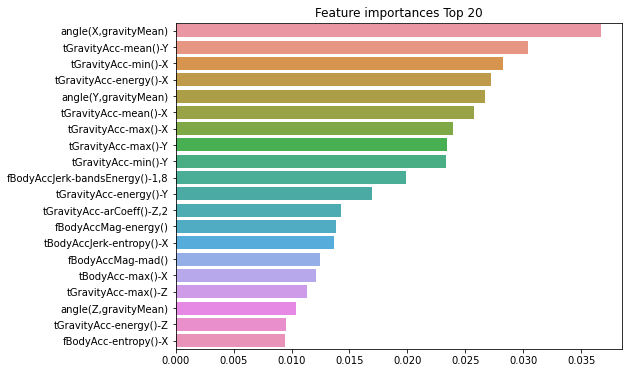

In [ ]:
# feature_importances_ 속성을 이용하여
# 알고리즘이 선택한 피처의 중요도 확인
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 위에서 찾은 최적 하이퍼 파라미터로 학습한 estimator에 대해, 피처 중요도 파악
best_rf_clf = grid_cv.best_estimator_

ftr_importances_value = best_rf_clf.feature_importances_

# 피처의 중요도와 데이터 컬럼(특징 이름) 매칭 
ftr_importances = pd.Series(ftr_importances_value, index=X_train.columns)

# 시리즈를 통해 값을 내림차순으로 정렬하고, 상위 20개 가져옴
ftr_top20 = ftr_importances.sort_values(ascending = False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

3. GBM(Gradient Boosting Machine)

In [ ]:
# 여러 개의 약한 학습기를 순차적으로 학습-예측하면서
# 잘못 예측한 데이터에 가중치 부여를 통해 오류 개선

# GBM(가중치 업데이트를 경사 하강법으로 활용)
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정을 위함. 시작 시간 설정.
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print('GBM 수행 시간: {0:.1f} 초'.format(time.time() - start_time))

GBM 정확도: 0.9386
GBM 수행 시간: 719.7 초


In [ ]:
from sklearn.model_selection import GridSearchCV

params ={
    'n_estimators' :[100,500],
    'leanring_rate' :[0.05, 0.1]
}

grid_cv = GridSearchCV(gb_clf, param_grid=params, cv=2, verbose=1)
grid_cv.fit(X_train, y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

# GridSearchCV를 이용해 최적으로 학습된 estimator로 예측 수행
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))